In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import nivapy
import gdal
import matplotlib.pyplot as plt

# DOMQUA: Acid sensitivity for lakes

Leah has a list of nearly 5000 lakes across Fennoscandia (see e-mail received 08/05/2018 at 12.07). For each, we need some indication of "acid sensitivity". One way to do this would be to find watershed boundaries for the area upstream of each lake, and then use these to calculate summary statistics for acid sensitivity.

I have already roughly approximated global acid sensitivity based on geology for ICP Waters:

C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Acid_Sensitivity_Global_Geology

The aim of this notebook is to link Leah's site list to my acid sensitivity data. The main challenge here will be finding suitable catchment boundaries, but with a bit of luck the dataset previously supplied by Anders Finstad will have the required information.

## 1. Read site list

In [2]:
# Read site data
stn_xlsx = (r'K:\Prosjekter\Klima\O-13382 DomQua HWI\8 Future DOC'
            r'\Data\WaterChemistry\Nordic_survey_1995'
            r'\NordicSurvey_SiteProperties.xlsx')
stn_df = pd.read_excel(stn_xlsx, sheetname='DATA')

# Check for missing key data
assert pd.isnull(stn_df['Station_Code']).sum() == 0, 'Station codes missing.'
assert pd.isnull(stn_df['Latitude']).sum() == 0, 'Latitudes missing.'
assert pd.isnull(stn_df['Longitude']).sum() == 0, 'Longitudes missing.'

stn_df.head()

,StationID,Station_Code,Station_Name,Lake_Name,NVE _Vatn_nr,NVE_Vassdrag_nr,Latitude,Longitude,UTM_North_m,UTM_East_m,UTM_Zone,LakeArea_km2,CatchmentArea_km2
0,3441,1135-1-19,HOH 666,HOH 666,23544.0,037.C1B,59.724,6.566,6623185.0,363128.0,32.0,0.07,1.50
1,3224,826-1-18,Fikstjørn,Fikstjørn,12371.0,016.EAE,59.853,8.616,6635102.0,478486.0,32.0,0.07,0.40
2,3571,1431-2-35,Håheimsvatnet,Håheimsvatnet,29446.0,087.B1Z,61.591,6.508,6831148.0,367752.0,32.0,0.25,25.88
3,3013,221-1-9,Lembruvatna,Lembruvatna,3184.0,313.B,59.841,11.838,6637110.0,659023.0,32.0,0.09,6.90
4,3552,1422-3-18,Starsjøen,Starsjøen,1567.0,073.CBD,60.972,8.017,6760067.0,446788.0,32.0,1.91,9.70


## 2. Read spatial data

In [3]:
# Connect to postgis
pg_eng = nivapy.da.connect(src='postgres')

Username: ········
Password: ········
Connection successful.


In [4]:
# Extract spatial data 
sql = ("SELECT geom, lake_id, lake_name, catchment_area_km2 "
       "FROM niva_work.nope_metals.ecco_biwa")

crs = {'init': 'epsg:25833'} # ETRS89 UTM Zone 33N

cat_gdf = gpd.GeoDataFrame.from_postgis(sql, 
                                        geom_col='geom', 
                                        crs=crs, 
                                        con=pg_eng)

print 'Total number of catchments:', len(cat_gdf)

cat_gdf.head()

Total number of catchments: 4677


,geom,lake_id,lake_name,catchment_area_km2
0,"(POLYGON ((311315 6571695, 311265 6571695, 311...",118-1-7,HOH113,0.4296
1,"(POLYGON ((690295 7028195, 690235 7028195, 690...",3208,ÄLVSJÖSJÖN,14.5066
2,"(POLYGON ((289485 6645005, 289465 6645005, 289...",227-2-1,Heia,17.5300
3,"(POLYGON ((1142355 6930165, 1142335 6930165, 1...",Fin-605,LÖYTYNLAMPI,1.7645
4,"(POLYGON ((528245 7042245, 528245 7042275, 528...",868,MÖRTSJÖN,46.6771


## 3. Join on attributes

In principle, it should be possible to join the spatial and non-spatial datasets by linking `'Station_Code'` to `'lake_id'`. Unfortunately, the `'lake_ids'` for Norwegian sites in Anders' dataset are not reliable - see [here](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/nope_metals_3.ipynb#7.3.-Link-lake-chemistry-to-moss-and-geochemistry-datasets) for details. 

In addition, it appears that Finnish sites in Anders' dataset are named `'Fin-XXX'`, whereas those in Leah's data are `'FIN-XXX'`, while Swedish sites are `'XXX'` in the catchment data and `'SWE-XXX'` in the stations table. Linking based on attributes is therefore not straightforward and will stake some figuring out.

### 3.1. Clean catchment data

In [5]:
# Replace 'Fin' with 'FIN' in spatial data
cat_gdf['lake_id'] = cat_gdf['lake_id'].str.replace('Fin', 'FIN')

# Remove 'SWE-' from station data
stn_df['Station_Code'] = stn_df['Station_Code'].str.replace('SWE-', '')

# Add unique catchment ID to gdf (as lake_id is broken)
cat_gdf['cat_id'] = cat_gdf.index

# Container for matches
match_list = []

# Loop over site data
for idx, row in stn_df.iterrows():
    # Get site info
    code = row['Station_Code']
    name = row['Station_Name']
    
    # Has the lake ID been truncated?
    if len(code) > 8:
        # Truncated
        tr_code = code[:8]
        
        # Get matches based on truncated code
        code_mat_df = cat_gdf.query('lake_id == @tr_code')
        
        # Is there a unique match for the truncated code?
        if len(code_mat_df) == 1:
            # Yes
            match_list.append(code_mat_df['cat_id'].values[0])
            
        else:
            # No. Can we match based on name as well?
            name_mat_df = code_mat_df.query('lake_name == @name')
            
            # Do we now have a unique match?
            if len(name_mat_df) == 1:
                # Yes
                match_list.append(name_mat_df['cat_id'].values[0])
                
            elif len(name_mat_df) == 0:
                # No matches found
                match_list.append('No match')
            
            else:
                # Multiple matches
                match_list.append('Multiple matches')
    else:
        # Not truncated. Should be able to match lake ID exactly
        code_mat_df = cat_gdf.query('lake_id == @code')
        
        # Is there a unique match?
        if len(code_mat_df) == 1:
            # Yes
            match_list.append(code_mat_df['cat_id'].values[0])        
        
        elif len(code_mat_df) == 0:
            # No matches found
            match_list.append('No match')

        else:
            # Can we match on name as well?
            name_mat_df = code_mat_df.query('lake_name == @name')
            
            # Do we now have a unique match?
            if len(name_mat_df) == 1:
                # Yes
                match_list.append(name_mat_df['cat_id'].values[0])
                
            elif len(name_mat_df) == 0:
                # No matches found
                match_list.append('No match')
            
            else:
                # Multiple matches
                match_list.append('Multiple matches')
            
# Add col to wc_df
stn_df['match_ids'] = match_list

### 3.2. Join datasets

In [6]:
# Join station data to spatial data
cat_gdf = cat_gdf.merge(stn_df, 
                        left_on='cat_id', 
                        right_on='match_ids',
                        how='inner')

print len(cat_gdf)

cat_gdf.head()

4648


,geom,lake_id,lake_name,catchment_area_km2,cat_id,StationID,Station_Code,Station_Name,Lake_Name,NVE _Vatn_nr,NVE_Vassdrag_nr,Latitude,Longitude,UTM_North_m,UTM_East_m,UTM_Zone,LakeArea_km2,CatchmentArea_km2,match_ids
0,"(POLYGON ((311315 6571695, 311265 6571695, 311...",118-1-7,HOH113,0.4296,0,3002,118-1-7,HOH113,HOH113,3494.0,001.D1,59.245,11.690,6570429.0,653420.0,32.0,0.05,0.65,0
1,"(POLYGON ((690295 7028195, 690235 7028195, 690...",3208,ÄLVSJÖSJÖN,14.5066,1,8637,3208,ÄLVSJÖSJÖN,ÄLVSJÖSJÖN,NaN,NaN,63.348,18.778,7026290.0,388808.0,34.0,NaN,NaN,1
2,"(POLYGON ((289485 6645005, 289465 6645005, 289...",227-2-1,Heia,17.5300,2,3015,227-2-1,Heia,Heia,3107.0,002.D1,59.929,11.222,6645588.0,624187.0,32.0,0.53,17.91,2
3,"(POLYGON ((1142355 6930165, 1142335 6930165, 1...",FIN-605,LÖYTYNLAMPI,1.7645,3,1379,FIN-605,LÖYTYNLAMPI,LÖYTYNLAMPI,NaN,NaN,61.962,27.321,6869988.0,516833.0,35.0,NaN,NaN,3
4,"(POLYGON ((528245 7042245, 528245 7042275, 528...",868,MÖRTSJÖN,46.6771,4,8937,868,MÖRTSJÖN,MÖRTSJÖN,NaN,NaN,63.492,15.590,7040543.0,529380.0,33.0,NaN,NaN,4


This cleaning seems to work quite well - I can now match 4648 out of 4677 catchments in the spatial dataset. However, as a final check, it is worth comparing the `'Station_Name'` and `'lake_name'` columns.

In [7]:
# Compare names between datasets
comp_gdf = cat_gdf[(cat_gdf['lake_name']!=cat_gdf['Station_Name'])]
comp_gdf

,geom,lake_id,lake_name,catchment_area_km2,cat_id,StationID,Station_Code,Station_Name,Lake_Name,NVE _Vatn_nr,NVE_Vassdrag_nr,Latitude,Longitude,UTM_North_m,UTM_East_m,UTM_Zone,LakeArea_km2,CatchmentArea_km2,match_ids
34,"(POLYGON ((147085 6528785, 147065 6528785, 147...",912-2-27,Ljøsvatnet,0.5151,34,3280,912-2-27,Ljøsvannet,Ljøsvannet,9183.0,018.E,58.757000,8.901000,6512998.0,494272.0,32.0,0.14,0.50,34
56,"(POLYGON ((635435 7205415, 635395 7205415, 635...",1384,None,0.8335,56,9099,1384,NaN,NaN,NaN,NaN,64.955000,17.852000,7206477.0,634681.0,33.0,NaN,NaN,56
103,"(POLYGON ((603815 7372165, 603805 7372165, 603...",692,None,0.2321,103,9510,692,NaN,NaN,NaN,NaN,66.449000,17.330000,7371894.0,603868.0,33.0,NaN,NaN,103
145,"(POLYGON ((503215 7293075, 503115 7293075, 503...",374,None,0.0035,145,9029,374,NaN,NaN,NaN,NaN,65.761000,15.072000,7293272.0,503298.0,33.0,NaN,NaN,145
160,"(POLYGON ((501495 7275335, 501485 7275335, 501...",373,None,0.0215,160,9028,373,NaN,NaN,NaN,NaN,65.602000,15.036000,7275549.0,501659.0,33.0,NaN,NaN,160
183,"(POLYGON ((704175 7556215, 704155 7556215, 704...",339,None,0.6233,183,9433,339,NaN,NaN,NaN,NaN,68.051000,19.887000,7548968.0,453575.0,34.0,NaN,NaN,183
197,"(POLYGON ((638515 7417025, 638505 7417025, 638...",826,None,1.3719,197,9538,826,NaN,NaN,NaN,NaN,66.843000,18.162000,7416714.0,375493.0,34.0,NaN,NaN,197
202,"(POLYGON ((483005 7303315, 482975 7303315, 482...",372,None,0.1849,202,9027,372,NaN,NaN,NaN,NaN,65.859000,14.646000,7304239.0,483844.0,33.0,NaN,NaN,202
208,"(POLYGON ((146885 6525325, 146875 6525325, 146...",912-2-18,Ljøstadvatnet,10.3983,208,3279,912-2-18,Ljøstadvann,Ljøstadvann,9198.0,018.E,58.751622,8.898039,6512400.0,494100.0,32.0,0.44,11.10,208
230,"(POLYGON ((305235 7133505, 305185 7133505, 305...",1725-3-1,Bjørfarvatnet,3.6628,230,193,1725-3-14,BjÃ¸rfarvatnet,BjÃ¸rfarvatn,40844.0,138.BA1Z,64.277881,10.986769,7134112.0,305755.0,33.0,1.01,3.80,230


From a quick skim, this output looks sensible.

In [8]:
# Convert dtypes for 'StationID' for Fiona
cat_gdf['StationID'] = cat_gdf['StationID'].astype(int)

# Tidy up
cat_gdf['cat_a1_km2'] = cat_gdf['catchment_area_km2']
cat_gdf['cat_a2_km2'] = cat_gdf['CatchmentArea_km2']
cat_gdf['stn_id'] = cat_gdf['StationID']
cat_gdf['stn_code'] = cat_gdf['Station_Code']
cat_gdf['stn_name'] = cat_gdf['Station_Name']
cat_gdf['lake_name'] = cat_gdf['Lake_Name']
cat_gdf['lat'] = cat_gdf['Latitude']
cat_gdf['lon'] = cat_gdf['Longitude']
cat_gdf['lake_a_km2'] = cat_gdf['LakeArea_km2']

# Just cols of interest
cat_gdf = cat_gdf[['geom', 'stn_id', 'stn_code', 'stn_name', 
                   'lake_name', 'lat', 'lon', 'lake_a_km2', 
                   'cat_a1_km2', 'cat_a2_km2']]

cat_gdf.head()

,geom,stn_id,stn_code,stn_name,lake_name,lat,lon,lake_a_km2,cat_a1_km2,cat_a2_km2
0,"(POLYGON ((311315 6571695, 311265 6571695, 311...",3002,118-1-7,HOH113,HOH113,59.245,11.690,0.05,0.4296,0.65
1,"(POLYGON ((690295 7028195, 690235 7028195, 690...",8637,3208,ÄLVSJÖSJÖN,ÄLVSJÖSJÖN,63.348,18.778,NaN,14.5066,NaN
2,"(POLYGON ((289485 6645005, 289465 6645005, 289...",3015,227-2-1,Heia,Heia,59.929,11.222,0.53,17.5300,17.91
3,"(POLYGON ((1142355 6930165, 1142335 6930165, 1...",1379,FIN-605,LÖYTYNLAMPI,LÖYTYNLAMPI,61.962,27.321,NaN,1.7645,NaN
4,"(POLYGON ((528245 7042245, 528245 7042275, 528...",8937,868,MÖRTSJÖN,MÖRTSJÖN,63.492,15.590,NaN,46.6771,NaN


## 4. Reproject

We are interested in calculating areas, so it is important to work in an appropriate projection. From the previuous DOMQUA interpolation work, an suitable projection is defined [here](http://nbviewer.jupyter.org/github/JamesSample/spatial_interpolation/blob/master/spatial_interpolation_2.ipynb#1.-Define-projection).

The code below transforms the catchments to this project and calculates areas for each catchment. This means we have three different area columns in this shapefile:

 * `'cat_a1_km2'`: Areas from Anders' dataset
 * `'cat_a2_km2'`: Areas from Leah's Excel file
 * `'cat_a3_km2'`: Areas calculated here
 
In principle, these should all be the same, but in practice they probably aren't.

In [9]:
# Reproject
prj_str = (r'+a=6378137.0 +b=6356752.31425 +y_0=1000000.0 '
           r'+lon_0=15.0 +proj=aea +x_0=1000000.0 +units=m '
           r'+lat_2=73.0 +lat_1=53.0 +lat_0=63.0')
cat_gdf = cat_gdf.to_crs(prj_str)

# Calculate areas
cat_gdf['cat_a3_km2'] = cat_gdf['geom'].area/ 10**6

# Save as shapefile
shp_path = (r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua'
            r'\GIS\Shapefiles\fenno_lake_catchments.shp')
cat_gdf.to_file(shp_path)

cat_gdf.head()

,geom,stn_id,stn_code,stn_name,lake_name,lat,lon,lake_a_km2,cat_a1_km2,cat_a2_km2,cat_a3_km2
0,(POLYGON ((813402.6409328766 580355.9583254356...,3002,118-1-7,HOH113,HOH113,59.245,11.690,0.05,0.4296,0.65,0.429569
1,(POLYGON ((1187516.991692292 1042991.993198768...,8637,3208,ÄLVSJÖSJÖN,ÄLVSJÖSJÖN,63.348,18.778,NaN,14.5066,NaN,14.505439
2,(POLYGON ((791988.7782015004 654515.1163823853...,3015,227-2-1,Heia,Heia,59.929,11.222,0.53,17.5300,17.91,17.525041
3,(POLYGON ((1632560.637072651 941389.9366115584...,1379,FIN-605,LÖYTYNLAMPI,LÖYTYNLAMPI,61.962,27.321,NaN,1.7645,NaN,1.748133
4,(POLYGON ((1027834.220977661 1057525.639020381...,8937,868,MÖRTSJÖN,MÖRTSJÖN,63.492,15.590,NaN,46.6771,NaN,46.713266


## 5. Geology data

I will convert the geology data to a 1 km resolution raster, which can be used for zonal statistics. I've used one of the rasters created during the spatial interpolation workflow to provide a "snap raster".

### 5.1. Read lithological data

In [10]:
# Lookup table matching geol classes to acid sensitivity
geo_xlsx = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters'
            r'\Acid_Sensitivity_Global_Geology\Geol_Acid_Sens_Lookup.xlsx')
geo_cl = pd.read_excel(geo_xlsx, sheetname='lookup')

geo_cl

,Lith_ID,Lith_Code,Lithol,Ac_Sen_ID,Acid_Sens,Unc,Conf
0,1,su,Unconsolidated sediments,1,Low,High,Low
1,2,ss,Siliciclastic sedimentary rocks,3,High,Low,High
2,3,py,Pyroclastics,-1,Unknown,Low,High
3,4,sm,Mixed sedimentary rocks,2,Medium,High,Low
4,5,sc,Carbonate sedimentary rocks,1,Low,Low,High
5,6,ev,Evaporites,1,Low,Low,High
6,7,va,Acid volcanic rocks,3,High,Low,High
7,8,vi,Intermediate volcanic rocks,2,Medium,Low,High
8,9,vb,Basic volcanic rocks,1,Low,Low,High
9,10,pa,Acid plutonic rocks,3,High,Low,High


In [11]:
# Read geology data
geo_path = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters'
            r'\Acid_Sensitivity_Global_Geology\Raw_GIS_Datasets'
            r'\Europe\Acid_Sensitivity_Europe.shp')

geo_gdf = gpd.read_file(geo_path)

geo_gdf = geo_gdf[['geometry', 'Lith_Code']]

# Reproject
geo_gdf = geo_gdf.to_crs(prj_str)

# Join litho data
geo_gdf = geo_gdf.merge(geo_cl, 
                        on='Lith_Code', 
                        how='left')

# Save as shapefile
shp_path = (r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua'
            r'\GIS\Shapefiles\fenno_geol_prj.shp')
geo_gdf.to_file(shp_path)

geo_gdf.head()

,geometry,Lith_Code,Lith_ID,Lithol,Ac_Sen_ID,Acid_Sens,Unc,Conf
0,POLYGON ((-236388.7165094903 -324398.500731719...,ss,2,Siliciclastic sedimentary rocks,3,High,Low,High
1,POLYGON ((-235568.8445246767 -323379.436579627...,pb,12,Basic plutonic rocks,2,Medium,Low,High
2,POLYGON ((-236238.840949476 -324135.3598107996...,pa,10,Acid plutonic rocks,3,High,Low,High
3,(POLYGON ((-217435.1564357686 -328188.04977631...,pa,10,Acid plutonic rocks,3,High,Low,High
4,(POLYGON ((-211785.2985701182 -331313.70342388...,pa,10,Acid plutonic rocks,3,High,Low,High


### 5.2. Rasterise

In [12]:
# Convert to raster
geo_tif = (r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua'
           r'\GIS\Shapefiles\fenno_1km_geol.tif')

snap_ras = (r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua'
            r'\GIS\Shapefiles\fenno_1km_snap_ras.tif')

nivapy.spatial.shp_to_ras(shp_path, 
                          geo_tif, 
                          snap_ras, 
                          'Ac_Sen_ID', 
                          -9, 
                          gdal.GDT_Int16)

## 6. Zonal statistics

In [13]:
# Create dict mapping integer IDs to zone names
geo_cl.index = geo_cl['Ac_Sen_ID']
zone_dict = geo_cl['Acid_Sens'].to_dict()

zone_dict

{-1: nan, 1: u'Low', 2: u'Medium', 3: u'High'}

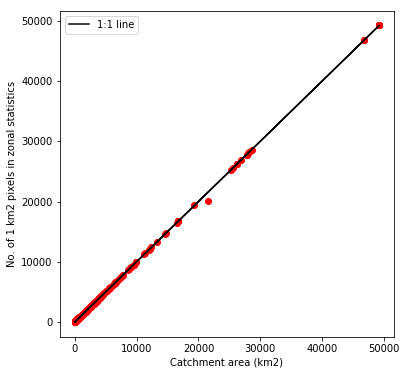

In [20]:
# Zonal stats
vec_path = (r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua'
            r'\GIS\Shapefiles\fenno_lake_catchments.shp')

stat_df = nivapy.spatial.zonal_stats(vec_path, 
                                     geo_tif, 
                                     -9, 
                                     categorical=True, 
                                     category_map=zone_dict)

# Fill NaN with zero
stat_df.fillna(0, inplace=True)

# Add total column
stat_df['Total'] = stat_df['Low'] + stat_df['Medium'] + stat_df['High']

# Append to catchment data
cat_df = pd.concat([cat_gdf, stat_df], axis=1)
del cat_df['geom']

# Check sum of pixels is roughly equal to catchment area
fig = plt.figure(figsize=(6,6))
plt.plot(cat_df['cat_a3_km2'], cat_df['Total'], 'ro', label='')
plt.plot(cat_df['cat_a3_km2'], cat_df['cat_a3_km2'], 'k-', label='1:1 line')
plt.xlabel('Catchment area (km2)')
plt.ylabel('No. of 1 km2 pixels in zonal statistics')
plt.legend(loc='best')

In [21]:
# Save
out_csv = (r'K:\Prosjekter\Klima\O-13382 DomQua HWI\8 Future DOC'
           r'\Data\WaterChemistry\Nordic_survey_1995'
           r'\nordic_survey_acid_sens.csv')

cat_df.to_csv(out_csv, index=False, encoding='utf-8')

cat_df.head()

,stn_id,stn_code,stn_name,lake_name,lat,lon,lake_a_km2,cat_a1_km2,cat_a2_km2,cat_a3_km2,High,Low,Medium,Total
0,3002,118-1-7,HOH113,HOH113,59.245,11.690,0.05,0.4296,0.65,0.429569,1.0,0.0,0.0,1.0
1,8637,3208,ÄLVSJÖSJÖN,ÄLVSJÖSJÖN,63.348,18.778,NaN,14.5066,NaN,14.505439,14.0,0.0,2.0,16.0
2,3015,227-2-1,Heia,Heia,59.929,11.222,0.53,17.5300,17.91,17.525041,17.0,0.0,0.0,17.0
3,1379,FIN-605,LÖYTYNLAMPI,LÖYTYNLAMPI,61.962,27.321,NaN,1.7645,NaN,1.748133,2.0,0.0,0.0,2.0
4,8937,868,MÖRTSJÖN,MÖRTSJÖN,63.492,15.590,NaN,46.6771,NaN,46.713266,44.0,0.0,0.0,44.0
